# Implementacion de UNET para mejoramiento de imagenes
### Notebook con proceso de entrenamiento
Se implementó una arquitectura similar a la propuesta en https://arxiv.org/pdf/1901.06081.pdf, una UNet para mejorar la calidad de las imagenes con texto de manera que facilite la tarea del OCR.<br>
Se utilizaron datasets de DIBCO para realizar el entrenamiento generando diferentes parches. El presente notebook muestra el proceso de entrenamiento del modelo y un breve ejemplo del funcionamiento.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

    
from argparse import Namespace
import time 
import random

In [21]:
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.utils import shuffle

from PIL import Image
import PIL
import os

### Preprocesamiento
Proceso de obtencion de los parches de entrenamiento, los cuales se encontraban en un directorio local.<br>
NOTA: debido al peso los datasets no se subieron a git, pero estan disponibles en https://vc.ee.duth.gr/dibco2019/

In [22]:
dirs = ['dibco2018/','dibco2017/','dibco2011/','dibco2012/','dibco2016/']
path = 'data_docs/'
dir_list = []
dir_list_gt = []
for d in dirs:
    curr_dir = path+d
    print(f'Checking dir {curr_dir}')
    for filename in os.listdir(curr_dir+'Dataset'):
        if (filename.endswith('.bmp')|filename.endswith('.png')|filename.endswith('.tiff')):
            #print(filename)
            dir_list.append(curr_dir+'Dataset/'+filename)
            #dir_list_np.append(filename)
            for filename2 in os.listdir(curr_dir+'GT'):
                #print(filename2)
                if (filename2==filename[:-4]+'_gt.bmp')|(filename2==filename[:-4]+'_gt.tiff')|(filename2==filename[:-4]+'_gt.tif'):
                    #print(filename2)
                    dir_list_gt.append(curr_dir+'GT/'+filename2)

Checking dir data_docs/dibco2018/
Checking dir data_docs/dibco2017/
Checking dir data_docs/dibco2011/
Checking dir data_docs/dibco2012/
Checking dir data_docs/dibco2016/


In [23]:
#shuffles dir list

shuffler = np.random.permutation(len(dir_list))

dir_list, dir_list_gt = shuffle(dir_list, dir_list_gt)
ranidx = random.randint(0,len(dir_list)-1)
print(f'{dir_list[ranidx]}  {dir_list_gt[ranidx]}')

data_docs/dibco2012/Dataset/H07.png  data_docs/dibco2012/GT/H07_gt.bmp


#### Funciones auxiliares de entrenamiento

In [28]:
def image_augmentation(img):
    #proceso para aumentar los datos
    img_w,img_h=img.size
    scales = [1,1.5,1.25,1.5]
    img1 = img.resize((int(scales[0]*img_w),int(scales[0]*img_h)), Image.ANTIALIAS)
    img1 = img1.transpose(Image.ROTATE_270)
    img2 = img.resize((int(scales[1]*img_w),int(scales[1]*img_h)), Image.ANTIALIAS)
    img3 = img.resize((int(scales[2]*img_w),int(scales[2]*img_h)), Image.ANTIALIAS)
    img3 = img3.transpose(Image.FLIP_LEFT_RIGHT)
    #img4 = img.resize((int(scales[3]*img_w),int(scales[3]*img_h)), Image.ANTIALIAS)
    img.close()
    #returns them in a np array
    img1=np.asarray(img1)
    img2=np.asarray(img2)
    img3=np.asarray(img3)
    
    return [img1,img2,img3]

def get_gt(x_pat,y_pat):
    gt_pat = np.zeros(y_pat.shape)
    for i in range(len(x_pat)):
        bgcol = np.mean(x_pat[i],axis=(0,1))
        gt_pat_tmp = np.zeros(y_pat[i].shape)
        gt_pat_tmp[np.where((y_pat[i]==[255,255,255]).all(axis=2))]=bgcol
        gt_pat[i]=gt_pat_tmp
    return x_pat,gt_pat.astype(int)

def generate_patches(data_x,data_y,b_size,p_size):
    '''
    generates patches with ground truth
    '''
    ran_state = random.randint(0,1000)
    #data_x = np.asarray(img_x)
    #data_y = np.asarray(img_y)
    x_pat = extract_patches_2d(data_x, p_size,max_patches=b_size,random_state=ran_state)
    y_pat = extract_patches_2d(data_y, p_size,max_patches=b_size,random_state=ran_state)
    x_pat,y_pat=get_gt(x_pat,y_pat)
    return x_pat,y_pat

def get_patchBatch(img_x,img_y,args):
    slice_size=args.b_size//4
    data_x = np.asarray(img_x)
    data_y = np.asarray(img_y)
    data_x1,data_x2,data_x3 = image_augmentation(img_x)
    data_y1,data_y2,data_y3 = image_augmentation(img_y)
    xp1,yp1=generate_patches(data_x,data_y,b_size=slice_size,p_size=args.patch_size)
    xp2,yp2=generate_patches(data_x1,data_y1,b_size=slice_size,p_size=args.patch_size)
    xp3,yp3=generate_patches(data_x2,data_y2,b_size=slice_size,p_size=args.patch_size)
    xp4,yp4=generate_patches(data_x3,data_y3,b_size=slice_size,p_size=args.patch_size)
    xp=np.concatenate((xp1,xp2,xp3,xp4),axis=0)
    yp=np.concatenate((yp1,yp2,yp3,yp4),axis=0)
    return xp,yp

def load_img(idx,dirs,dirs_gt,args):
    '''
    takes images index and lists of dirs and dirs gt
    '''
    x_path = dirs[idx]
    y_path = dirs_gt[idx]
    image_x = Image.open(x_path)
    image_y = Image.open(y_path)
    
    #if (y_path.endswith('.tiff')|y_path.endswith('.tif')):
    image_y=image_y.convert("RGB")
    
    xp,yp=get_patchBatch(image_x,image_y,args=args)
    image_x.close()
    image_y.close()
    train_x = torch.from_numpy(xp).type(torch.LongTensor)/255.#
    train_y = torch.from_numpy(yp).type(torch.LongTensor)/255.#/255.
    train_x = train_x.permute(0,3,1,2)
    train_y = train_y.permute(0,3,1,2)
    return train_x,train_y

In [29]:
#dataset de entrenamiento
class PatchesDataset(Dataset):
    def __init__(self, dirs_x, dirs_y,args):
        self.dirs = dirs_x
        self.dirs_gt = dirs_y
        #self.n_patches = num_patches
        self.datasize =len(dirs_x)
        self.args = args
    def __len__(self):
        return self.datasize

    def __getitem__(self, idx):
        #print(f'Getting image {self.dirs[idx]} and GT {self.dirs_gt[idx]}')
        tr_x,tr_y=load_img(idx,self.dirs,self.dirs_gt,self.args)
        
        return tr_x,tr_y

In [30]:
args = Namespace()
#args.batch_size=128
args.b_size = 12
args.num_epochs = 10000
args.patch_size = (256,256)
#args.N_patches = 1000 #patches per training sample
args.savedir = 'checkpoints'

#train/test dirs
ratio = 0.8
cut = int(0.8*len(dir_list))
train_dir = dir_list[:cut]
train_dir_gt = dir_list_gt[:cut]
test_dir = dir_list[cut:]
test_dir_gt = dir_list_gt[cut:]

In [31]:
#genera datasets de entrenamiento y validacion

train_ds = PatchesDataset(train_dir,train_dir_gt,args)
train_loader= torch.utils.data.DataLoader(train_ds,batch_size=1,shuffle=True) 

val_ds = PatchesDataset(test_dir,test_dir_gt,args)
val_loader= torch.utils.data.DataLoader(val_ds,batch_size=1,shuffle=True) 

In [32]:
data = next(iter(val_loader))

Text(0.5, 1.0, 'binarized')

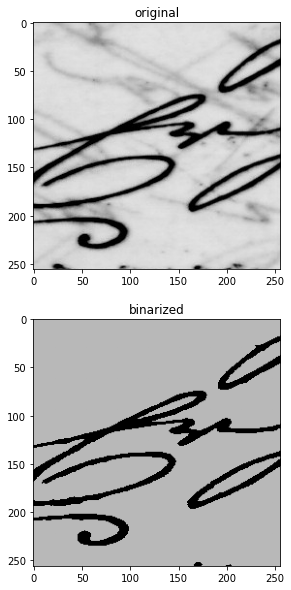

In [33]:
#ejemplo de datos de entrenamiento
ii=2
img_x = data[0][0].permute(0,2,3,1)
img_y= data[1][0].permute(0,2,3,1)
plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.imshow(img_x[ii])
plt.title('original')
plt.subplot(2,1,2)
plt.imshow(img_y[ii])
plt.title('binarized')

### Modelo

In [34]:
#UNET 

class doubleconv2d(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        #bloque de convolucion doble
        self.doubleconv=nn.Sequential(
            nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,padding=1),
            nn.LeakyReLU(0.25,inplace=True),
            nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,padding=1),
            nn.LeakyReLU(0.25,inplace=True)
            )
    def forward(self,x):
        return self.doubleconv(x)
#bloque de bajada
class Down(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            doubleconv2d(in_ch,out_ch)
        )
    def forward(self,x):
        return self.down(x)

#bloque de subida
class Up(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        self.up=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)
        self.conv = doubleconv2d(in_ch,out_ch)

    def forward(self,x1,x2):
        x1 = self.up(x1)

        #ajusta las dimensiones para la concatenacion (en caso de ser necesario)
        dY = x2.size()[2] - x1.size()[2]
        dX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [dX // 2, dX - dX // 2, dY // 2, dY - dY // 2])

        x = torch.cat([x2, x1], dim=1) 
        return self.conv(x)

class output_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(output_layer, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [36]:
filters = [16,32,64,128,256]#[64,128,256,512,1024]
#definicion de unet 
class UNet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(UNet,self).__init__()
        #capa de entrada
        self.in_layer = doubleconv2d(in_ch,filters[0])
        #capas Down
        self.down1 = Down(filters[0], filters[1])
        self.down2 = Down(filters[1], filters[2])
        self.down3 = Down(filters[2], filters[3])
        self.down4 = Down(filters[3], filters[3])
        #capas Up
        self.up1 = Up(filters[4], filters[2])
        self.up2 = Up(filters[3], filters[1])
        self.up3 = Up(filters[2], filters[0])
        self.up4 = Up(filters[1], filters[0])
        #capa de salida
        self.out_layer = output_layer(filters[0], out_ch)
    def forward(self,x):
        
        x1 = self.in_layer(x)
        
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        out = self.out_layer(x)
        return out

In [37]:
#model = UNet(in_ch=3,out_ch=3)
model = UNet(in_ch=3,out_ch=3)
model.cuda()
model.load_state_dict(torch.load('checkpoints/simpleUnet/checkpoint.pt')['state_dict'])
#podemos ver el resumen de la red
from torchsummary import summary
#summary(model,(3,64,64))

#### Entrenamiento de la red, (se entreno por aproximadamente 35000 iteraciones)

In [40]:
#fcn para evualuar en validacion
def model_eval(data_loader,model,gpu=False):
    with torch.no_grad():
        losses = []
        for i,(imgs_x,imgs_y) in enumerate(data_loader):
            Xval = Variable(imgs_x.view(-1,3,args.patch_size[0],args.patch_size[1])).cuda() 
            Yval = Variable(imgs_y.view(-1,3,args.patch_size[0],args.patch_size[1])).cuda()
            outputsVal = model(Xval)
            loss = error(outputsVal,Yval)
            losses.append(loss.cpu().data)
    return np.mean(losses)


def save_checkpoint(state,is_best,checkpoint_path,filename='checkpoint.pt'):
    filename = os.path.join(checkpoint_path,filename)
    torch.save(state,filename)
    if is_best:
        shutil.copyfile(filename,os.path.join(checkpoint_path,'model_best.pt'))

In [41]:
#loss & optimizer
error = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4,betas=(0.9,0.999),
                             eps=1e-08,weight_decay=0.00001)
args.savedir = 'checkpoints'

In [42]:
torch.cuda.empty_cache()

In [43]:

tic = time.time()
count = 0
prev_bestloss = 100
loss_list = []
val_loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(args.num_epochs):
    for i,(imgs_x,imgs_y) in enumerate (train_loader):
        
        X = Variable(imgs_x.view(-1,3,args.patch_size[0],args.patch_size[1])).cuda() 
        Y = Variable(imgs_y.view(-1,3,args.patch_size[0],args.patch_size[1])).cuda() 

        optimizer.zero_grad() #borra el gradiente
        outputs = model(X) #propagacion
        loss = error(outputs,Y) #calcula el error
        loss.backward()    #retropropaga error
        optimizer.step()   #actualiza los parámetros
        count +=1
        
        if count%50 ==0:
            iteration_list.append(count)
            loss_list.append(loss.item())
            val_loss = model_eval(val_loader,model,gpu=True)
            val_loss_list.append(val_loss)
            print('epoch: {} iter:{} loss:{} val loss {}'.format(epoch,count,loss.data,val_loss))
            if(val_loss<prev_bestloss):
                prev_bestloss = val_loss
                save_checkpoint(
                    {
                        'epoch':epoch+1,
                        'state_dict':model.state_dict(),
                        'optimizer':optimizer.state_dict(),
                    },
                    False,
                    args.savedir
                )
                print('Checkpoint saved')
            
print('elapsed = ',time.time()-tic)

KeyboardInterrupt: 

In [44]:
best_model = UNet(in_ch=3,out_ch=3)
best_model.cuda()
#best_model.load_state_dict(torch.load('checkpoints/simpleUnet/checkpoint.pt')['state_dict'])
best_model.load_state_dict(torch.load('checkpoints/simpleUNet/checkpoint.pt')['state_dict'])
best_model.train(False)

UNet(
  (in_layer): doubleconv2d(
    (doubleconv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.25, inplace=True)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.25, inplace=True)
    )
  )
  (down1): Down(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): doubleconv2d(
        (doubleconv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.25, inplace=True)
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): LeakyReLU(negative_slope=0.25, inplace=True)
        )
      )
    )
  )
  (down2): Down(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): doubleconv2d(
        (doub

### Ejemplo de inferencia en parches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'binarized 4')

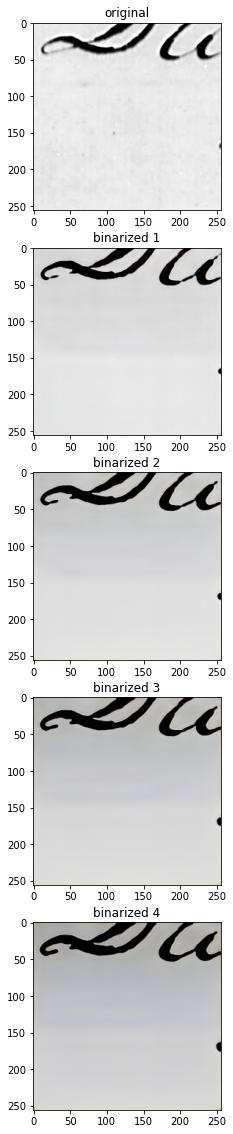

In [46]:
#checking inference on patches
data = next(iter(val_loader))

X_infer = Variable(data[0].view(-1,3,args.patch_size[0],args.patch_size[1])).cuda() 
Y_infer = best_model(X_infer)
Y_infer2 = best_model(Y_infer)
Y_infer3 = best_model(Y_infer2)
Y_infer4 = best_model(Y_infer3)
Y_infer =Y_infer.cpu().detach()
Y_infer2 =Y_infer2.cpu().detach()
Y_infer3 =Y_infer3.cpu().detach()
Y_infer4 =Y_infer4.cpu().detach()


img_x = data[0][0].permute(0,2,3,1)
img_y= Y_infer.permute(0,2,3,1)
img_y2= Y_infer2.permute(0,2,3,1)
img_y3= Y_infer3.permute(0,2,3,1)
img_y4= Y_infer4.permute(0,2,3,1)



plt.figure(figsize=(5,20))
plt.subplot(5,1,1)
plt.imshow(img_x[0])
plt.title('original')
plt.subplot(5,1,2)
plt.imshow(img_y[0])
plt.title('binarized 1')
plt.subplot(5,1,3)
plt.imshow(img_y2[0])
plt.title('binarized 2')
plt.subplot(5,1,4)
plt.imshow(img_y3[0])
plt.title('binarized 3')

plt.subplot(5,1,5)
plt.imshow(img_y4[0])
plt.title('binarized 4')

In [47]:

#otsu thresholding
from skimage.filters import threshold_otsu
#no se uso
def otsu_thres(img_array):
    print(f'Otsu image shape {img_array.shape}')
    clipped = (np.clip(img_array, a_min = 0.0, a_max = 1.0)*255).astype(np.uint8)
    #tst = (tst*255).astype(np.uint8)
    image = Image.fromarray(clipped).convert('L')
    #image = image.convert('L')
    image = np.asarray(image)
    thresh = threshold_otsu(image)
    print(f'Threshold is {thresh}')
    binary = image > thresh
    binary = 1*binary
    return binary



### Funciones auxiliares para hacer inferencias en imagenes grandes usando parches

In [52]:
#image inferenc
def np_infer(model,arr):
    '''
    Takes numpy array and model and makes inferences
    '''
    #tt = transforms.ToTensor()
    X =  torch.from_numpy(arr)#tt(arr)
    X = X.permute(0,3,1,2)
    #X=X.view(-1,3,X.shape[1],X.shape[2])
    x_totrain = Variable(X).float().cuda()
    ypred = model(x_totrain)
    #ypred = model(ypred)
    ret=ypred.permute(0,2,3,1).detach().cpu().numpy()
    return ret#otsu_thres(ret)
#for splitting image and doing inference
def split_img(im,k=4):
    #im = tmphat[0]
    M = im.shape[0]//k
    modM = im.shape[0]%k
    N = im.shape[1]//k
    modN = im.shape[1]%k
    image_tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0]-modM,M) for y in range(0,im.shape[1]-modN,N)]
    #print(f'cdcd {(M*k)} {(N*k)}')
    return image_tiles

def join_img(image_tiles):
    '''
    takes list of arrays splitted by  spli img and joins them into an image
    '''
    K = int(np.sqrt(len(image_tiles)))
    for i in range(0,K*K,K):
        if i<(K*K-K):
            tiles = image_tiles[i:(i+K)]
        else:
            tiles = image_tiles[i:]
        tmp = np.concatenate((tiles),axis=1)
        if i==0:
            tst = tmp
        else:
            tst = np.concatenate((tst,tmp),axis=0)
    return tst
def process_tiles(model,tiles):
    '''
    Processes tiles with the unet model and otsu
    '''
    new_tiles = []
    for tile in tiles:
        w,h,ch=tile.shape
        tile = tile.reshape(-1,w,h,ch)/255.
        infer = np_infer(model,tile)
        infer = infer.reshape(w,h,ch)
        new_tiles.append(infer)
    return new_tiles

def process_image(img,model,scale=1.,k=0,contrast=1):
    img=PIL.ImageEnhance.Contrast(img).enhance(contrast)
    wTest1,hTest1 = img1.size
    if(k==0):
        '''
        set k auto
        '''
        k = int(np.ceil(((wTest1+hTest1)*0.5)/256.))
        print(f'k chosen {k}')
    new_size=(int(scale*wTest1),int(scale*hTest1))
    img = img.resize(new_size)
    img = np.asarray(img)
    #plt.imshow(img)
    img_tiles = split_img(img,k=k)
    print(f'Tile shape : {img_tiles[0].shape}')
    img_tiles = process_tiles(model,img_tiles)
    #print(len(img_tiles))
    img_final = join_img(img_tiles)
    img_final = (np.clip(img_final, a_min = 0.0, a_max = 1.0)*255).astype(np.uint8)
    #print(img_final.shape)
    return img_final

def display_example(img,img_proc):
    plt.figure(figsize=(20,40))
    plt.subplot(2,1,1)
    plt.imshow(img1)
    plt.title('original')
    plt.subplot(2,1,2)
    plt.imshow(endimg)
    plt.title('UNet')

k chosen 12
Tile shape : (216, 288, 3)


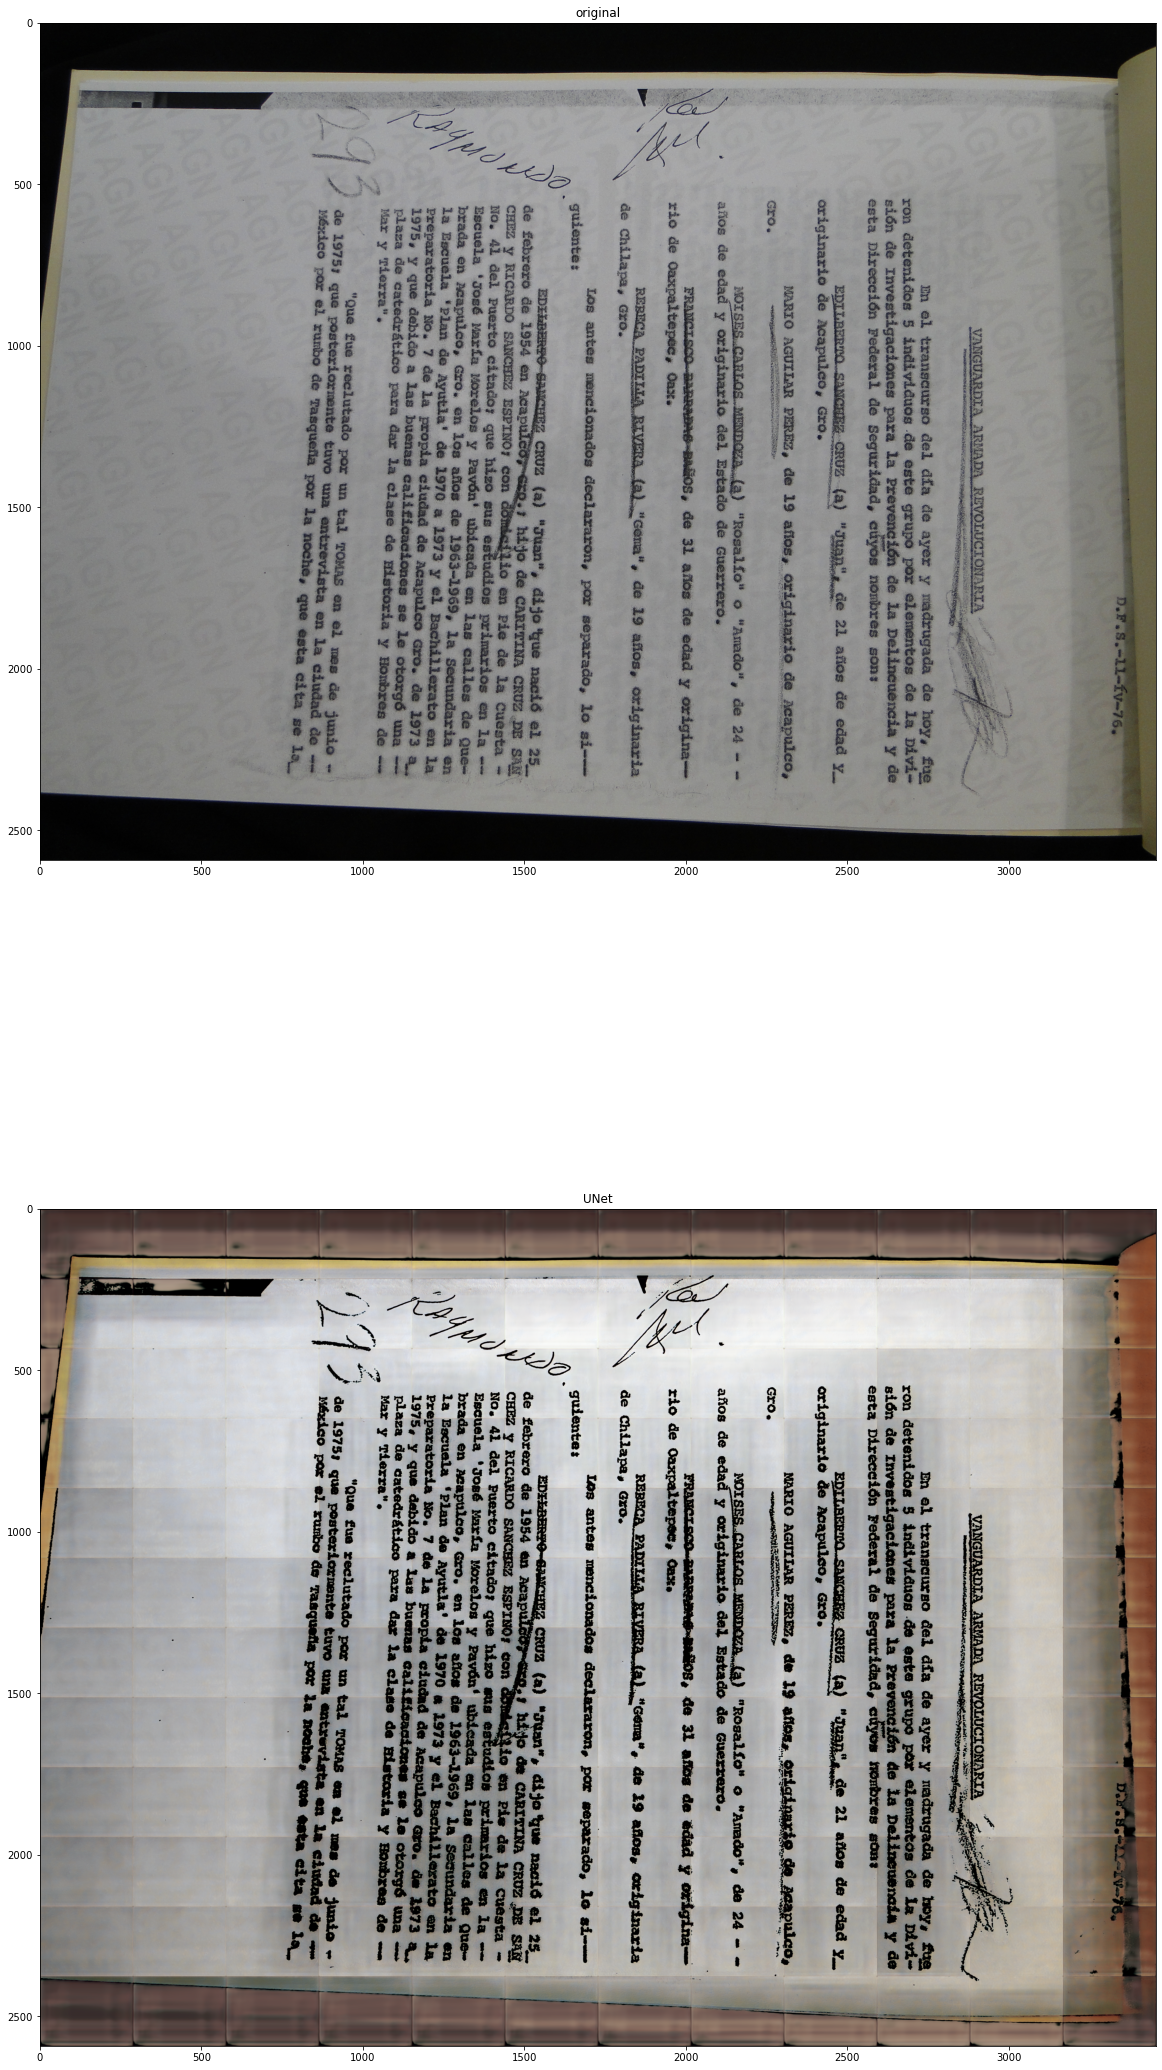

In [53]:
testing_path = 'data_riiaa/val'
test_fnames=os.listdir(testing_path)
idx = 5
img1=Image.open(testing_path+'/'+test_fnames[idx])
endimg = process_image(img1,best_model,scale=1,k=0,contrast=3)
display_example(img1,endimg)
